In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [5]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
# block_size = 3
# X, Y = [], []

# for word in words:
#     context = [0] * block_size
#     for ch in word + '.':
#         ix = stoi[ch]
#         X.append(context)
#         Y.append(ix)
#         # print(''.join(itos[c] for c in context), '-->', itos[ix])
#         context = context[1:] + [ix]

# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [8]:
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters)

10281

In [11]:
for p in parameters:
    p.requires_grad = True

In [12]:
lri, lossi = [], []
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

# find the suitable learning rate
for i in range(1000):
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))  # mini-batch's size: 32
    emb = C[Xtr[ix]]
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # shape: [32, 300]
    logits = h @ W2 + b2  # shape: [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    print(f'loss: {loss.item()}')
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track status
    lri.append(lre[i])
    lossi.append(loss.item())

loss: 30.89227294921875
loss: 22.04896354675293
loss: 25.01543617248535
loss: 24.289405822753906
loss: 25.442522048950195
loss: 25.07587242126465
loss: 24.732324600219727
loss: 24.741390228271484
loss: 23.90238380432129
loss: 23.681692123413086
loss: 22.158985137939453
loss: 24.156824111938477
loss: 29.818693161010742
loss: 20.13113021850586
loss: 25.92051124572754
loss: 25.127580642700195
loss: 29.22024154663086
loss: 23.516956329345703
loss: 25.97113609313965
loss: 24.566377639770508
loss: 25.32664680480957
loss: 21.97516441345215
loss: 27.39309310913086
loss: 25.92772674560547
loss: 23.21097183227539
loss: 26.38422393798828
loss: 26.06707000732422
loss: 19.721460342407227
loss: 27.650102615356445
loss: 24.625900268554688
loss: 22.921367645263672
loss: 23.33894920349121
loss: 21.485597610473633
loss: 24.96778678894043
loss: 23.613603591918945
loss: 26.61639976501465
loss: 31.637365341186523
loss: 26.509662628173828
loss: 25.210403442382812
loss: 27.880796432495117
loss: 20.3226642608

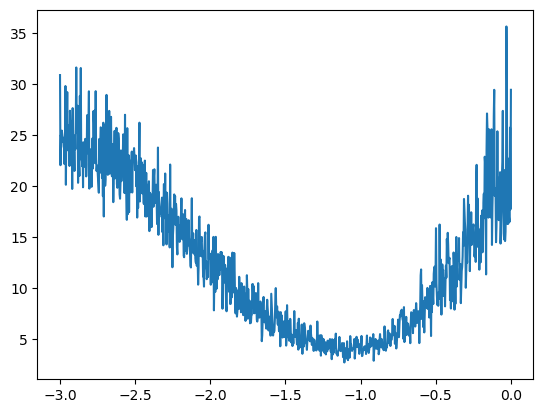

In [13]:
plt.plot(lri, lossi)
plt.show()

In [14]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(22.5507, grad_fn=<NllLossBackward0>)

In [15]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(22.6024, grad_fn=<NllLossBackward0>)

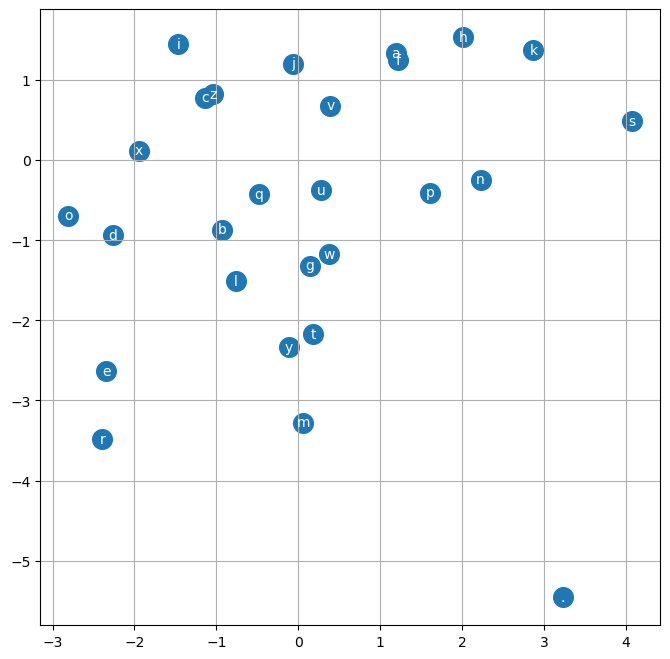

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha='center', va='center', color='white')
plt.grid('minor')